# NoiseFlow

> noiseflow


In [1]:
#| default_exp noiseflow

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide
from IPython.display import clear_output, DisplayHandle

def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
 #| export

from fastai.vision.all import nn, torch, np, Path, get_image_files, Image 
# from Noise2Model.utils import attributesFromDict
# from Noise2Model.models import DnCNN, UNet
# from Noise2Model.utils import gaussian_diag, batch_PSNR, weights_init_orthogonal #, weights_init_kaiming


## Normalizing Flows

In [5]:
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

### Set up model



1. Define flows


In [6]:
from fastai.data.all import *
from fastai.vision.all import *

In [7]:
   
K = 32
#torch.manual_seed(0)
b = torch.tensor([0, 1])
flows = []
for i in range(K):
    s = nf.nets.MLP([2, 4, 4, 2])
    t = nf.nets.MLP([2, 4, 4, 2])
if i % 2 == 0:
    flows += [nf.flows.MaskedAffineFlow(b, t, s)]
else:
    flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]


2. Set target and base distribution


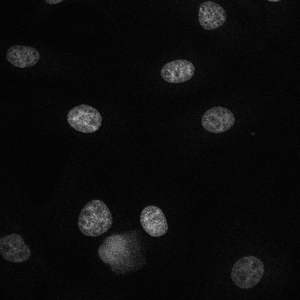

In [8]:
path = Path('../_data/Confocal_BPAE_B/')
path_train_raw = Path(path/"raw")
path_train_gt = Path(path/"gt")
raw_fnames = get_image_files(path_train_raw)
gt_fnames = get_image_files(path_train_gt)
img_gt = Image.open(gt_fnames[0])
img_raw = Image.open(raw_fnames[0])
img_raw.to_thumb(300)


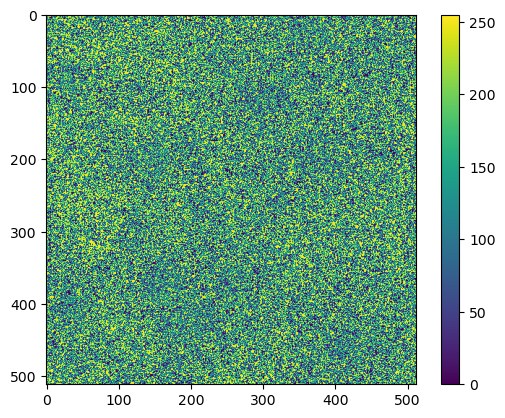

In [9]:
img = np.abs(np.asarray(img_raw) - np.asarray(img_gt)) # / 256.0
plt.imshow(img)
plt.colorbar()

In [10]:
target = nf.distributions.ImagePrior(img)
q0 = nf.distributions.base.DiagGaussian(2) # nf.distributions.DiagGaussian(2)

3. Construct flow model


In [11]:
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

4. Move model on GPU if available


In [12]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

### Plot prior distribution


/home/biagio/miniconda3/envs/n2m/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_276297/4103372968.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


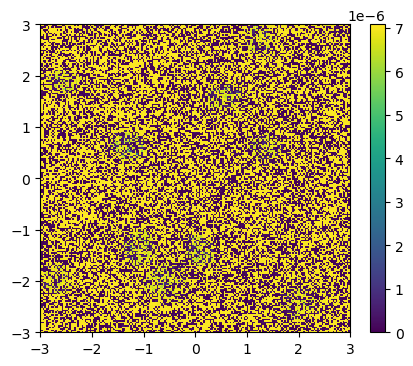

In [13]:
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 4))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.colorbar()
plt.show()


### Plot initial posterior distribution

/tmp/ipykernel_276297/2304229577.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


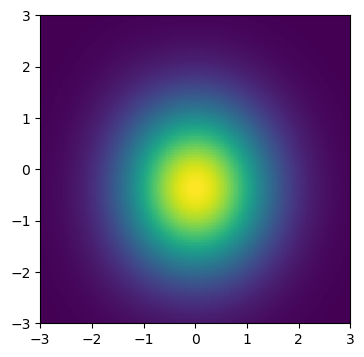

In [14]:
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()

## Train model


  5%|▍         | 4959/100000 [00:11<03:35, 441.21it/s]/tmp/ipykernel_276297/1319963912.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


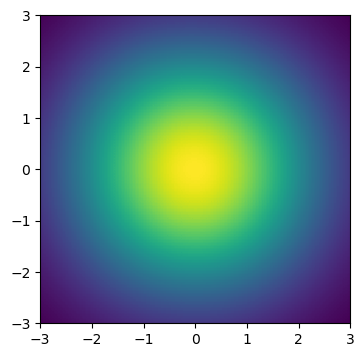

 10%|▉         | 9969/100000 [00:23<03:18, 452.89it/s]

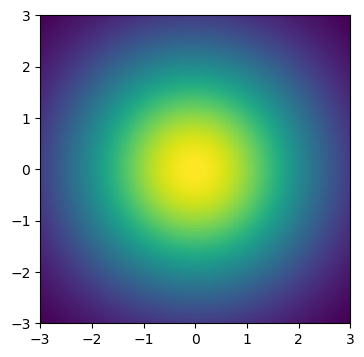

 15%|█▍        | 14970/100000 [00:34<03:20, 424.10it/s]

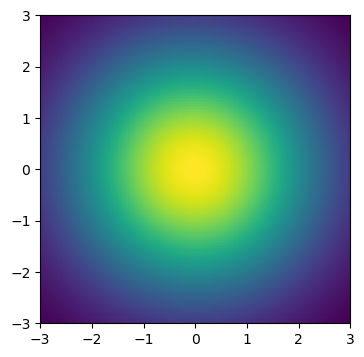

 20%|█▉        | 19958/100000 [00:46<03:11, 419.03it/s]

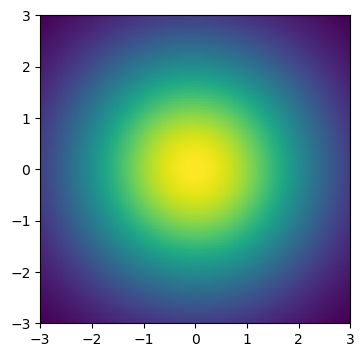

 25%|██▍       | 24983/100000 [00:58<02:57, 422.55it/s]

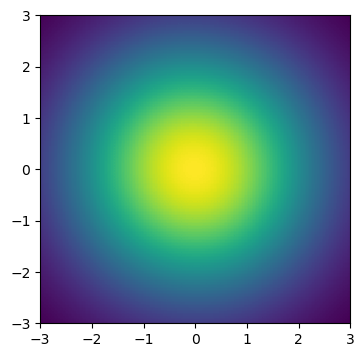

 30%|██▉       | 29956/100000 [01:09<02:47, 418.08it/s]

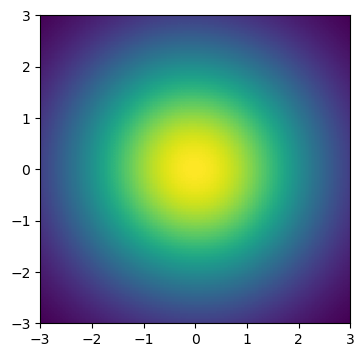

 35%|███▍      | 34981/100000 [01:21<02:28, 437.80it/s]

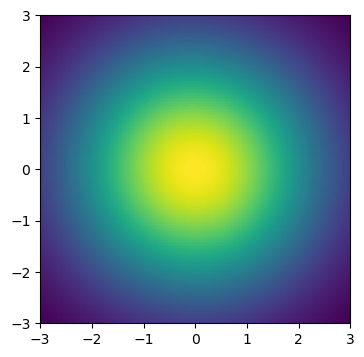

 40%|███▉      | 39989/100000 [01:33<02:24, 414.37it/s]

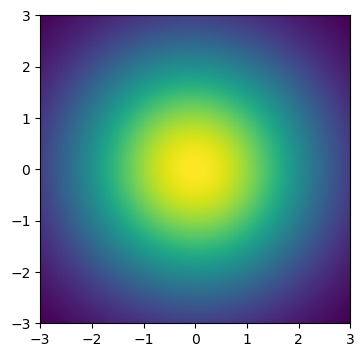

 45%|████▍     | 44976/100000 [01:44<02:12, 415.56it/s]

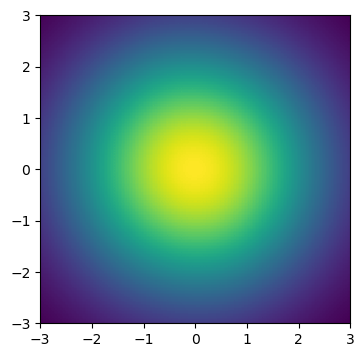

 50%|████▉     | 49974/100000 [01:56<01:52, 444.46it/s]

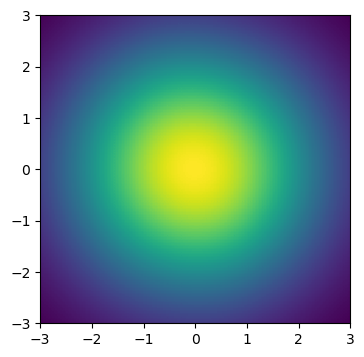

 55%|█████▍    | 54990/100000 [02:07<01:39, 452.22it/s]

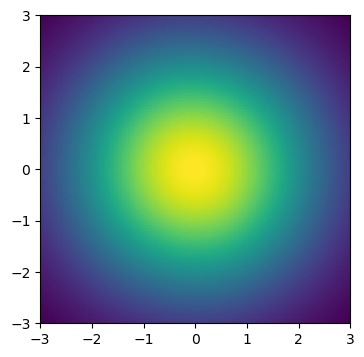

 60%|█████▉    | 59982/100000 [02:19<01:28, 453.17it/s]

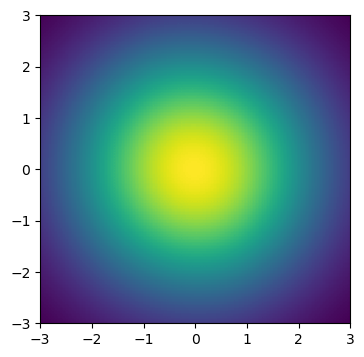

 65%|██████▍   | 64960/100000 [02:31<01:19, 443.21it/s]

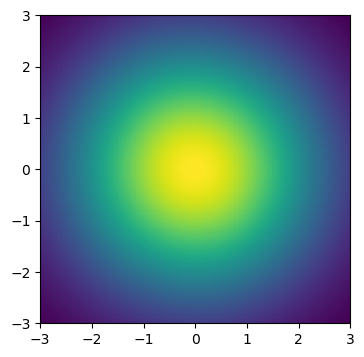

 70%|██████▉   | 69976/100000 [02:42<01:07, 445.15it/s]

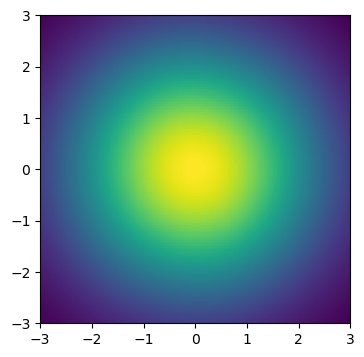

 75%|███████▍  | 74998/100000 [02:54<01:00, 414.30it/s]

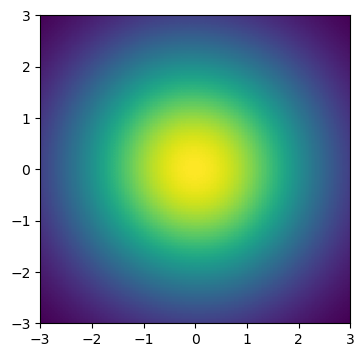

 80%|███████▉  | 79994/100000 [03:06<00:45, 436.29it/s]

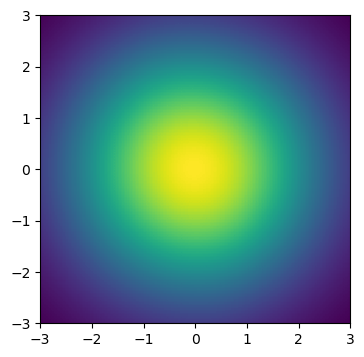

 85%|████████▍ | 84994/100000 [03:18<00:35, 423.11it/s]

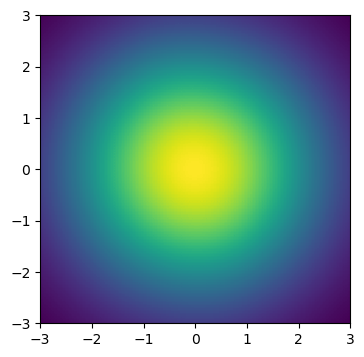

 90%|████████▉ | 89963/100000 [03:30<00:23, 435.66it/s]

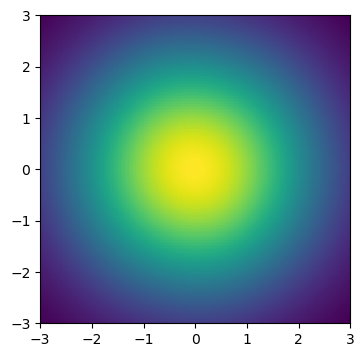

 95%|█████████▍| 94968/100000 [03:42<00:12, 412.22it/s]

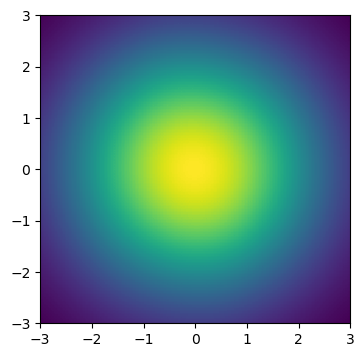

100%|█████████▉| 99974/100000 [03:54<00:00, 419.09it/s]

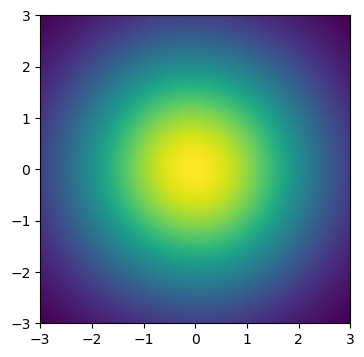

100%|██████████| 100000/100000 [03:54<00:00, 426.93it/s]


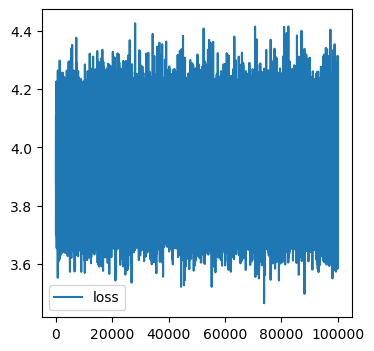

In [22]:
max_iter = 100000
num_samples = 2 * 16
show_iter = 5000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    x = nfm.p.sample(num_samples).double()
    loss = nfm.forward_kld(x)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(4, 4))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.show()

plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Plot learned distribution

/tmp/ipykernel_276297/2304229577.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


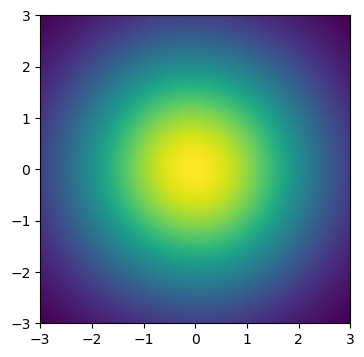

In [23]:
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()

# Noise Flow


In [17]:
#| export

# from Noise2Model.layers.conv2d1x1 import Conv2d1x1
# from Noise2Model.layers.affine_coupling import AffineCoupling, ShiftAndLogScale
# from Noise2Model.layers.signal_dependant import SignalDependant
# from Noise2Model.layers.gain import Gain
# from Noise2Model.layers.utils import SdnModelScale

In [18]:
# #| export
# class NoiseFlow(nn.Module):

#     def __init__(self, x_shape, arch, flow_permutation, param_inits, lu_decomp):
#         super(NoiseFlow, self).__init__()
#         attributesFromDict(locals( ))
#         self.model = nn.ModuleList(self.noise_flow_arch(x_shape))

#     def noise_flow_arch(self, x_shape):
#         arch_lyrs = self.arch.split('|')  # e.g., unc|sdn|unc|gain|unc
#         bijectors = []
#         for i, lyr in enumerate(arch_lyrs):
#             # is_last_layer = False

#             if lyr == 'unc':
#                 if self.flow_permutation == 0:
#                     pass
#                 elif self.flow_permutation == 1:
#                     print('|-Conv2d1x1')
#                     bijectors.append(
#                         Conv2d1x1(
#                             num_channels=x_shape[0],
#                             LU_decomposed=self.decomp,
#                             name='Conv2d_1x1_{}'.format(i)
#                         )
#                     )
#                 else:
#                     print('|-No permutation specified. Not using any.')
                    
#                 print('|-AffineCoupling')
#                 bijectors.append(
#                     AffineCoupling(
#                         x_shape=x_shape,
#                         shift_and_log_scale=ShiftAndLogScale,
#                         name='unc_%d' % i
#                     )
#                 )
#             # elif lyr == 'lt':
#             #     print('|-LinearTransfomation')
#             #     bijectors.append(
#             #         LinearTransformation(
#             #             name='lt_{}'.format(i),
#             #             device='cuda'
#             #         )
#             #     )
#             elif lyr == 'sdn':
#                 print('|-SignalDependant')
#                 bijectors.append(
#                     SignalDependant(
#                         name='sdn_%d' % i,
#                         scale=SdnModelScale,
#                         param_inits=self.param_inits
#                     )
#                 )
#             elif lyr == 'gain':
#                 print('|-Gain')
#                 bijectors.append(
#                     Gain(name='gain_%d' % i)
#                 )

#         return bijectors

#     def forward(self, x, **kwargs):
#         z = x
#         objective = torch.zeros(x.shape[0], dtype=torch.float32, device=x.device)
#         for bijector in self.model:
#             z, log_abs_det_J_inv = bijector._forward_and_log_det_jacobian(z, **kwargs)
#             objective += log_abs_det_J_inv

#             if 'writer' in kwargs.keys():
#                 kwargs['writer'].add_scalar('model/' + bijector.name, torch.mean(log_abs_det_J_inv), kwargs['step'])
#         return z, objective

#     def _loss(self, x, **kwargs):
#         z, objective = self.forward(x, **kwargs)
#         # base measure
#         logp, _ = self.prior("prior", x)

#         log_z = logp(z)
#         objective += log_z

#         if 'writer' in kwargs.keys():
#             kwargs['writer'].add_scalar('model/log_z', torch.mean(log_z), kwargs['step'])
#             kwargs['writer'].add_scalar('model/z', torch.mean(z), kwargs['step'])
#         nobj = - objective
#         # std. dev. of z
#         # mu_z = torch.mean(x, dim=[1, 2, 3])
#         var_z = torch.var(x, dim=[1, 2, 3])
#         sd_z = torch.mean(torch.sqrt(var_z))

#         return nobj, sd_z

#     def loss(self, x, **kwargs):
        
#         # if 'writer' in kwargs.keys():
#         #     batch_average = torch.mean(x, dim=0)
#         #     kwargs['writer'].add_histogram('real_noise', batch_average, kwargs['step'])
#         #     kwargs['writer'].add_scalar('real_noise_std', torch.std(batch_average), kwargs['step'])

#         nll, sd_z = self._loss(x=x, **kwargs)
#         nll_dim = torch.mean(nll) / np.prod(x.shape[1:])
#         # nll_dim = torch.mean(nll)      # The above line should be uncommented

#         return nll_dim, sd_z

#     def inverse(self, z, **kwargs):
#         x = z
#         for bijector in reversed(self.model):
#             x = bijector._inverse(x, **kwargs)
#         return x
    
#     def sample(self, eps_std=None, **kwargs):
#         _, sample = self.prior("prior", kwargs['clean'])
#         z = sample(eps_std)
#         x = self.inverse(z, **kwargs)
#         batch_average = torch.mean(x, dim=0)
#         if 'writer' in kwargs.keys():
#             kwargs['writer'].add_histogram('sample_noise', batch_average, kwargs['step'])
#             kwargs['writer'].add_scalar('sample_noise_std', torch.std(batch_average), kwargs['step'])

#         return x

#     def prior(self, name, x):
#         n_z = x.shape[1]
#         h = torch.zeros([x.shape[0]] +  [2 * n_z] + list(x.shape[2:4]), device=x.device)
#         pz = gaussian_diag(h[:, :n_z, :, :], h[:, n_z:, :, :])

#         def logp(z1):
#             objective = pz.logp(z1)
#             return objective

#         def sample(eps_std=None):
#             if eps_std is not None:
#                 z = pz.sample2(pz.eps * torch.reshape(eps_std, [-1, 1, 1, 1]))
#             else:
#                 z = pz.sample
#             return z

#         return logp, sample

In [19]:
# from torch import randn as torch_randn
# from fastai.vision.all import test_eq

In [20]:
# def init_params():
#     npcam = 3
#     c_i = 1.0
#     beta1_i = -5.0 / c_i
#     beta2_i = 0.0
#     gain_params_i = np.ndarray([5])
#     gain_params_i[:] = -5.0 / c_i
#     cam_params_i = np.ndarray([npcam, 5])
#     cam_params_i[:, :] = 1.0
#     return (c_i, beta1_i, beta2_i, gain_params_i, cam_params_i)

# x = torch_randn(16,1,64,64)
# xdim = len(x.shape)-2

# tst = NoiseFlow(x.shape[1:], arch='gain', flow_permutation=0, param_inits=init_params(), lu_decomp=0)
# mods = list(tst.children())
# print(mods)
# # test_eq(tst(x.cuda()).shape, [16, 1, 32, 64, 64])
# logp, sample = tst(x.cuda())
# print(logp.shape)
# print(sample.shape)

In [21]:
#| hide
import nbdev; nbdev.nbdev_export()